In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import zscore, ttest_rel, f_oneway, ttest_ind
from asccd import timit, preanalysis, erps, plotting, util
from asccd import temporal_receptive_field as trf
from scipy.signal import resample

from bokeh.plotting import figure, show
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

# load and print annotations of TIMIT sentences
#### This notebook doesn't show how these annotations are generated from the raw waveforms and praat annotations.


In [2]:
timit_annotation = timit.get_timit_annotations()
timit_annotation

time  pitch  intensity  log_hz  erb_rate  rel_pitch_global  \
fadg0_si1279 0    0.01    NaN        NaN     NaN       NaN               NaN   
             1    0.02    NaN        NaN     NaN       NaN               NaN   
             2    0.03    NaN      32.27     NaN       NaN               NaN   
             3    0.04    NaN      32.68     NaN       NaN               NaN   
             4    0.05    NaN      30.99     NaN       NaN               NaN   
...                ...    ...        ...     ...       ...               ...   
mzmb0_si1796 186  1.87    NaN      33.69     NaN       NaN               NaN   
             187  1.88    NaN      32.45     NaN       NaN               NaN   
             188  1.89    NaN        NaN     NaN       NaN               NaN   
             189  1.90    NaN        NaN     NaN       NaN               NaN   
             190  1.91    NaN        NaN     NaN       NaN               NaN   

                  rel_pitch_global_erb  abs_pitch  abs_pitch_erb  \
fadg0_si1279 0                     NaN        NaN            NaN   
             1                     NaN        NaN            NaN   
             2                     NaN        NaN            NaN   
             3                     NaN        NaN            NaN   
             4                     NaN        NaN            NaN   
...                                ...        ...            ...   
mzmb0_si1796 186                   NaN        NaN            NaN   
             187                   NaN        NaN            NaN   
             188                   NaN        NaN            NaN   
             189                   NaN        NaN            NaN   
             190                   NaN        NaN            NaN   

                  abs_pitch_change  ...  front  low back  plosive  fricative  \
fadg0_si1279 0                 NaN  ...      0    0    0        0          0   
             1                 NaN  ...      0    0    0        0          0   
             2                 NaN  ...      0    0    0        0          0   
             3                 NaN  ...      0    0    0        0          0   
             4                 NaN  ...      0    0    0        0          0   
...                            ...  ...    ...  ...  ...      ...        ...   
mzmb0_si1796 186               NaN  ...      0    0    0        0          0   
             187               NaN  ...      0    0    0        0          0   
             188               NaN  ...      0    0    0        0          0   
             189               NaN  ...      0    0    0        0          0   
             190               NaN  ...      0    0    0        0          0   

                  syllabic  nasal  voiced  obstruent  sonorant  
fadg0_si1279 0           0      0       0          0         0  
             1           0      0       0          0         0  
             2           0      0       0          0         0  
             3           0      0       0          0         0  
             4           0      0       0          0         0  
...                    ...    ...     ...        ...       ...  
mzmb0_si1796 186         0      0       0          0         0  
             187         0      0       0          0         0  
             188         0      0       0          0         0  
             189         0      0       0          0         0  
             190         0      0       0          0         0  

[101961 rows x 27 columns]

In [3]:
timit_annotation.keys()

Index(['time', 'pitch', 'intensity', 'log_hz', 'erb_rate', 'rel_pitch_global',
       'rel_pitch_global_erb', 'abs_pitch', 'abs_pitch_erb',
       'abs_pitch_change', 'abs_pitch_erb_change', 'zscore_intensity', 'phn',
       'dorsal', 'coronal', 'labial', 'high', 'front', 'low', 'back',
       'plosive', 'fricative', 'syllabic', 'nasal', 'voiced', 'obstruent',
       'sonorant'],
      dtype='object')

In [4]:
timit_syllables = timit.load_timit_syllables()
timit_syllables

start_times  end_times    syllable_phns
timit_name   syllable_index                                         
mmds0_si1973 0                  0.132250   0.230187       dh ax-h q 
             1                  0.230187   0.260813              eh 
             2                  0.260813   0.318500           nx ih 
             3                  0.318500   0.458813            m iy 
             4                  0.458813   0.672687    dcl d ih dcl 
...                                  ...        ...              ...
mbma1_si2207 0                  0.143063   0.337375            ae z 
             1                  0.337375   0.484500            w iy 
             2                  0.484500   0.720000          ey tcl 
             3                  0.720000   0.827000            w iy 
             4                  0.827000   1.317937  tcl t ao kcl t 

[4233 rows x 3 columns]

In [5]:
timit_phonemes = timit.get_timit_phonemes()
timit_phonemes

start_time  end_time  phn  silence
timit_name   phoneme_index                                    
makr0_si1352 0                0.000000  0.150000   h#     True
             1                0.150000  0.250625   ae    False
             2                0.250625  0.375625    s    False
             3                0.375625  0.496750   ah    False
             4                0.496750  0.513000  tcl    False
...                                ...       ...  ...      ...
mgaw0_si535  23               1.612500  1.652500    k    False
             24               1.652500  1.741500  axr    False
             25               1.741500  1.785875   ix    False
             26               1.785875  1.857500   ng    False
             27               1.857500  2.115000   h#     True

[12716 rows x 4 columns]

# Loading data

This notebooks doesn't show how raw data is preprocessed and then "preanalyzed". Skipping those for now, this shows how to load preanalysis results, which are:

1. high-gamma time course for each electrode for each block
2. times of stimulus presentation (in seconds from the start of the block)
3. stimulus names
4. analog signals, which are either the microphone or speaker channel. We mostly deal with the speaker channels (anin number 2 and 3) in perception tasks. This is the recording of what was played to the patient. 

In [6]:
subject = 'HS11'
all_hgs = [preanalysis.load_hg(subject, block) for block in range(9, 11)]
all_times = [preanalysis.load_times(subject, block) for block in range(9, 11)]
all_names = [timit.get_timit_names_for_timit_block(1), timit.get_timit_names_for_timit_block(5)]

In [7]:
all_hgs[0].shape

(128, 32600)

# plot averaged high-gamma response

In [8]:
# get_timelocked_activity returns an array of shape (n_chans, n_timepoints, n_trials) 
# which has hg activity that is timelocked to times (in seconds). 
# Default time course returned is -0.2s to 1.0s. 
Y_mats = []
for onsets_one_block, hg in zip(all_times, all_hgs):
    Y_mats.append(erps.get_timelocked_activity(onsets_one_block, hg))
Y_mats = np.concatenate(Y_mats, axis=2)
print(Y_mats.shape)

(128, 120, 224)


In [9]:
# find speech responsive channels
Y_mat_before_onset = np.nanmean(Y_mats[:, :30, :], axis=1)
Y_mat_after_onset = np.nanmean(Y_mats[:, 35:, :], axis=1)
results = ttest_rel(Y_mat_before_onset, Y_mat_after_onset, axis=1)
responsive_chans = np.arange((len(results.pvalue)))[results.pvalue < 0.01/(len(results.pvalue))]
print("speech responsive channels:")
print(responsive_chans)

speech responsive channels:
[ 37  38  39  40  41  48  49  50  52  53  54  55  56  57  58  64  65  66
  67  68  69  70  71  72  73  74  76  80  81  82  83  84  85  86  87  88
  89  90  96  97  98  99 100 101 102 103 104 112 113 114 116 118 119 121]


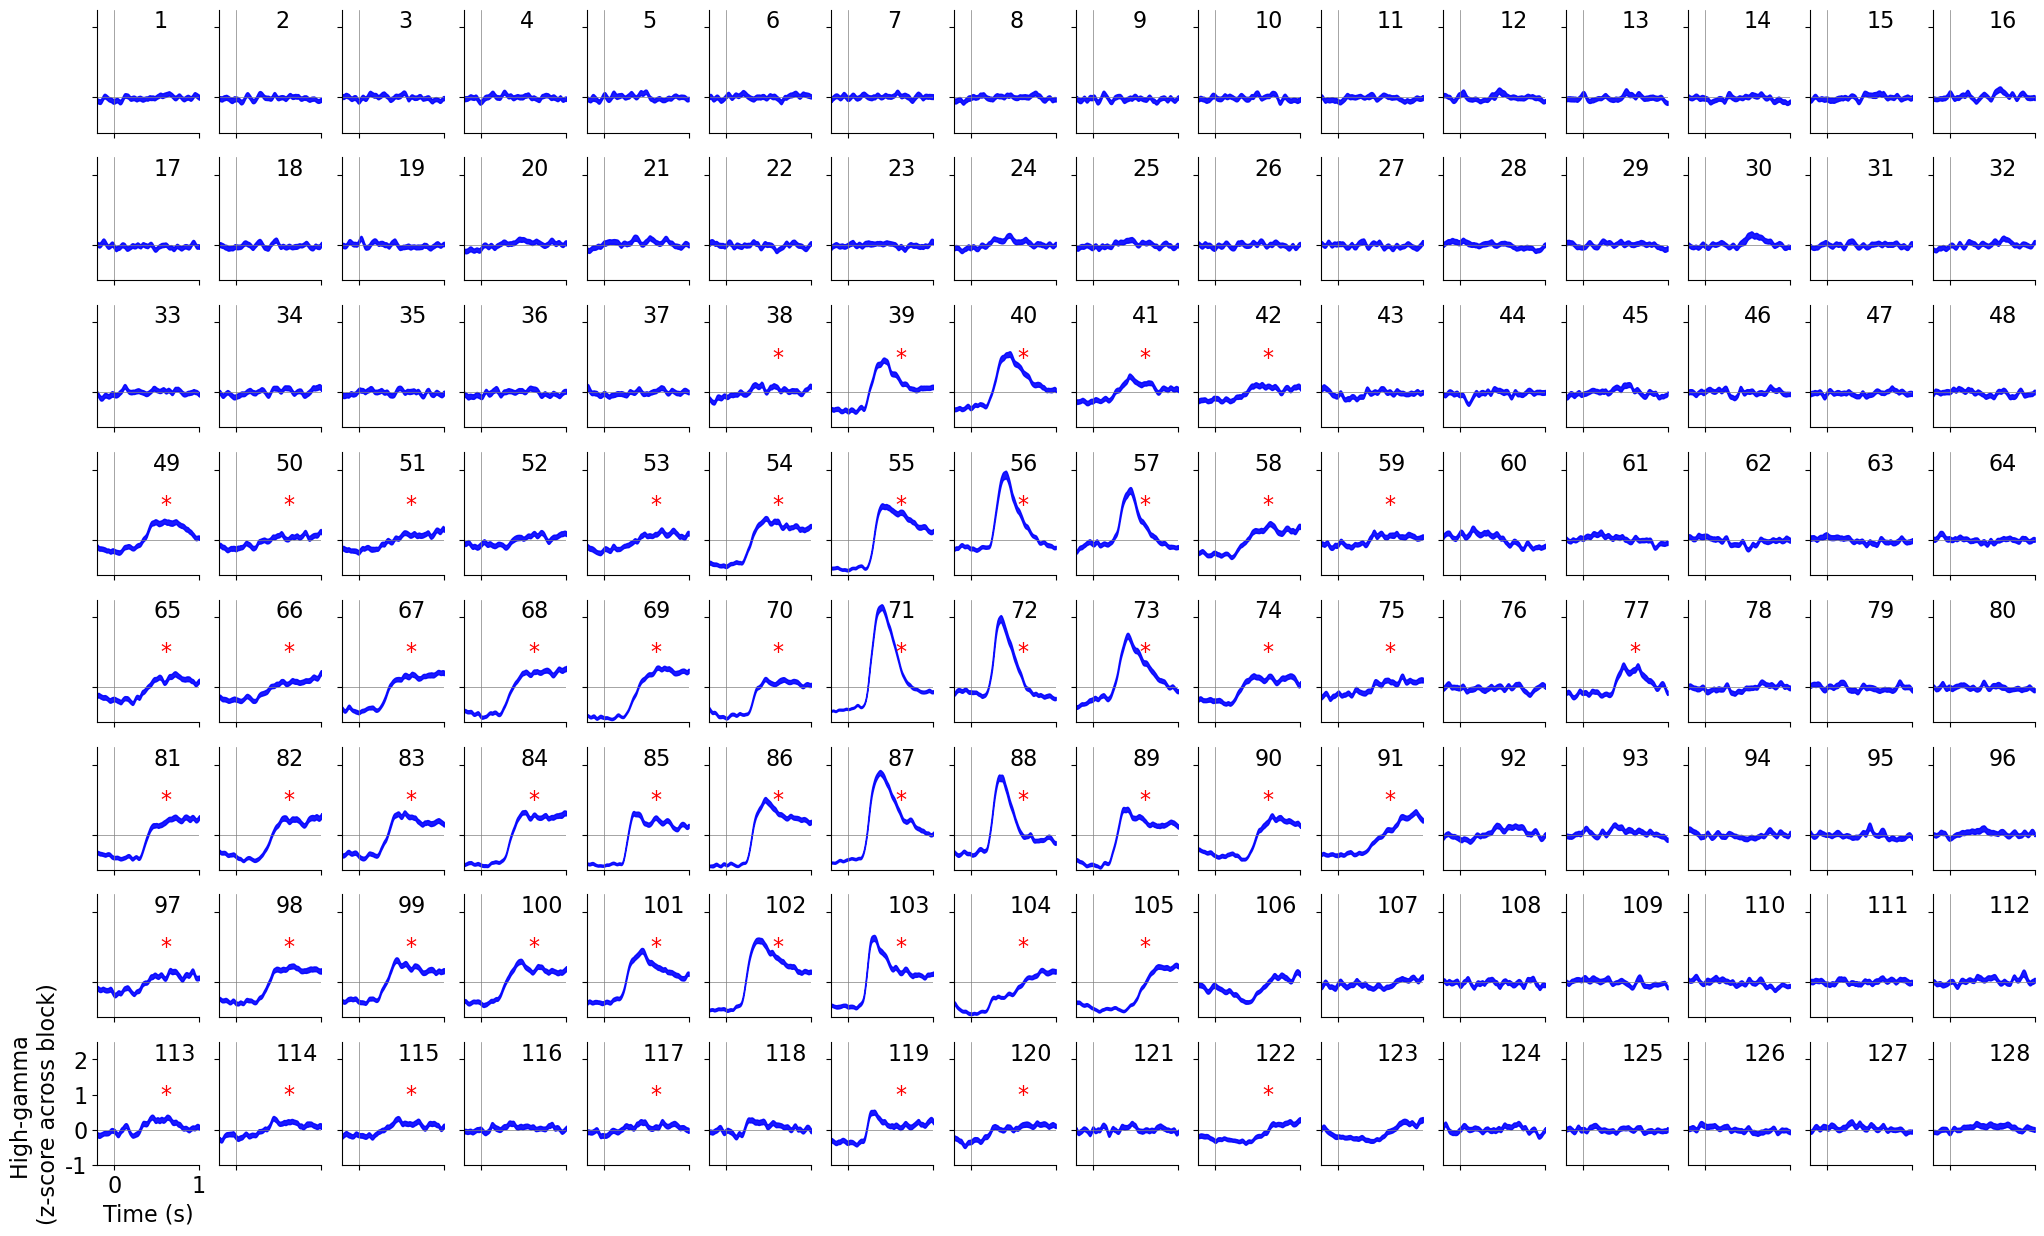

In [10]:
fig, axs = plt.subplots(8, 16, figsize=(25, 15))
axs = axs.flatten()

xvals = np.linspace(-0.2, 1, 120)

for i in range(128):
    plotting.plot_filled_sem(Y_mats[i], xvals, ax= axs[i], xlabel="", ylabel="",ylim=(-1,2.5), color='b')
    if i in responsive_chans:
        axs[i].text(0.55,0.8, '*', color='r')

for i, ax in enumerate(axs):
    ax.set(yticklabels=[], xticklabels=[], xticks=[0, 1])
    _ = ax.text(0.55, 0.85, str(i+1), transform=ax.transAxes)    
_ = axs[-16].set(yticks=[-1, 0, 1, 2], yticklabels=[-1, 0, 1, 2], xticklabels=[0, 1], xlabel="Time (s)", ylabel="High-gamma \n(z-score across block)")


# plot grids on cortical surface

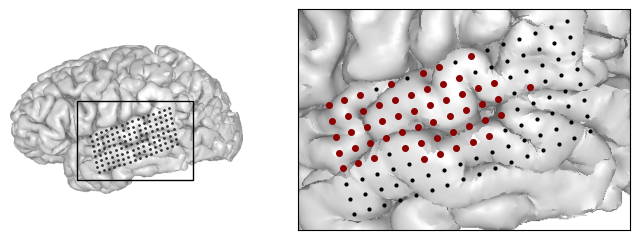

In [11]:
fig = plt.figure(figsize=(8, 4))

gs_brains = matplotlib.gridspec.GridSpec(1, 2, width_ratios=[0.7, 1], hspace=0.1)

ax_brain = plt.subplot(gs_brains[0])
ax_inset = plt.subplot(gs_brains[1])
plotting.brain_inset([ax_brain, ax_inset], subject='HS11', response_channels=responsive_chans)

# temporal receptive field analysis

In [12]:
delays = trf.get_delays(delay_seconds=0.4)

In [13]:
stim_resp = trf.get_trf_stim_resp(all_hgs, all_times, all_names)

In [14]:
features_full, Ys = trf.concatenate_trf_stim_resp(stim_resp, exclude=None)
features_no_rel, Ys = trf.concatenate_trf_stim_resp(stim_resp, exclude="rel")
features_no_change, Ys = trf.concatenate_trf_stim_resp(stim_resp, exclude="change")

In [15]:
print(features_full.shape)

(42010, 62)


In [16]:
print(Ys.shape)

(42010, 128)


In [17]:
test_corr_folds_chin, wts_folds_chin, best_alphas = trf.run_cv_temporal_ridge_regression_model(features_full, Ys, delays=delays, add_edges=False)
r2_full = np.mean(test_corr_folds_chin**2, axis=0)
wts_full = np.mean(wts_folds_chin, axis=0)

Running fold 0. Running fold 1. Running fold 2. Running fold 3. Running fold 4. 

In [18]:
test_corr_folds_chin, wts_folds_chin, best_alphas = trf.run_cv_temporal_ridge_regression_model(features_no_rel, Ys, delays=delays, add_edges=False)
r2_no_rel = np.mean(test_corr_folds_chin**2, axis=0)
wts_no_rel = np.mean(wts_folds_chin, axis=0)

Running fold 0. Running fold 1. Running fold 2. Running fold 3. Running fold 4. 

In [19]:
test_corr_folds_chin, wts_folds_chin, best_alphas = trf.run_cv_temporal_ridge_regression_model(features_no_change, Ys, delays=delays, add_edges=False)
r2_no_change = np.mean(test_corr_folds_chin**2, axis=0)
wts_no_change = np.mean(wts_folds_chin, axis=0)

Running fold 0. Running fold 1. Running fold 2. Running fold 3. Running fold 4. 

In [20]:
r2_rel_unique = r2_full - r2_no_rel
r2_change_unique = r2_full - r2_no_change

In [21]:
fig = figure(tools=['hover'], plot_width=340, plot_height=300)
fig.circle(x=r2_rel_unique, y=r2_change_unique)
fig.line(x=[0, 0.02], y=[0, 0.02])
show(fig)

# visualize temporal receptive fields

In [22]:
wts1_labels = {'yticks':(0, 3, 6, 9), 'yticklabels':(5.7, 0.2, -5.3, -10.8), 'ylabel':"Pitch change (oct/s)"}

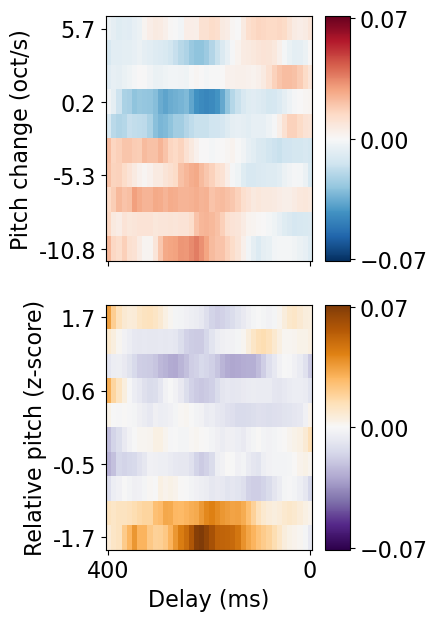

In [23]:
fig = trf.plot_trf(wts_full.T, 69, wts1_label=wts1_labels, wts_shape=(40, 62), wts1=(52, 62), wts2=(42, 52), min_max=(42,62), edges_added=False, figsize=(4.5,6.5))


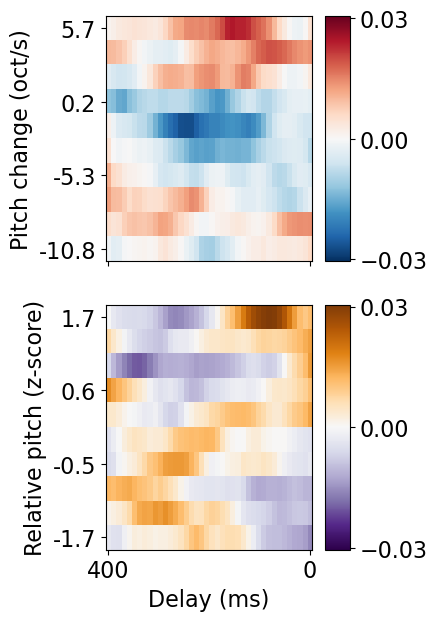

In [24]:
fig = trf.plot_trf(wts_full.T, 85, wts1_label=wts1_labels, wts_shape=(40, 62), wts1=(52, 62), wts2=(42, 52), min_max=(42,62), edges_added=False, figsize=(4.5,6.5))

# deep neural network models of speech

In [25]:
import torch
import torchaudio
from transformers import Wav2Vec2ForCTC
import os

In [26]:
timit_blocks = [1,2,3,4,5]
timit_names = []
for i in range(len(timit_blocks)):
    timit_names.append(timit.get_timit_names_for_timit_block(timit_blocks[i]))

In [27]:
pwd = os.getcwd()

In [28]:
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base", cache_dir=pwd)

/Users/yuanningli/opt/anaconda3/lib/python3.9/site-packages/transformers/configuration_utils.py:369: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of the model checkpoint at facebook/wav2vec2-base were not used when initializing Wav2Vec2ForCTC: ['quantizer.weight_proj.weight', 'project_q.bias', 'quantizer.codevectors', 'project_hid.weight', 'quantizer.weight_proj.bias', 'project_q.weight', 'project_hid.bias']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of 

In [29]:
model.eval()

Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (2): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (3): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (4): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)

# get all latent features

In [30]:
latent_feature_cnn = []  #[layers][block][sentence][time x feature]
latent_feature_ext = []  #[]
latent_feature_proj = []
latent_feature_encoder = []
latent_feature_en = []

latent_attention = []

for i in range(len(model.wav2vec2.feature_extractor.conv_layers)+1):
    latent_feature_cnn.append([])
    
for i in range(len(model.wav2vec2.encoder.layers)+1):
    latent_feature_encoder.append([])
    
for i in range(len(model.wav2vec2.encoder.layers)):
    latent_attention.append([])

for i in range(len(timit_names)):
    for j in range(len(latent_feature_cnn)):
        latent_feature_cnn[j].append([])
    for j in range(len(latent_feature_encoder)):
        latent_feature_encoder[j].append([])
    for j in range(len(latent_attention)):
        latent_attention[j].append([])
    latent_feature_ext.append([])
    latent_feature_proj.append([])
    latent_feature_en.append([])
    for j in range(len(timit_names[i])):
        print(timit_names[i][j])
        sound_file = timit.get_wavpath(timit_names[i][j])
        speech_array, sampling_rate = torchaudio.load(sound_file)

        # feature extraction
        lat = []
        lat.append(speech_array.unsqueeze_(0))
        
        for k in range(len(model.wav2vec2.feature_extractor.conv_layers)):
            lat.append(model.wav2vec2.feature_extractor.conv_layers[k](lat[k])) 
        for k in range(len(lat)):
            latent_feature_cnn[k][i].append(np.squeeze(lat[k].cpu().detach().numpy()))

        lat_p, ext_feat = model.wav2vec2.feature_projection(lat[-1].permute(0,2,1))
        lat_e = model.wav2vec2.encoder(lat_p, output_hidden_states=True, output_attentions=True)
        
        # encoder layers
        for k in range(len(lat_e.hidden_states)):
            latent_feature_encoder[k][i].append(np.squeeze(lat_e.hidden_states[k].cpu().detach().numpy()))
            
        for k in range(len(lat_e.attentions)):
            latent_attention[k][i].append(np.squeeze(lat_e.attentions[k].cpu().detach().numpy()))

        latent_feature_ext[i].append(np.squeeze(lat[-1].cpu().detach().numpy()).T)
        latent_feature_proj[i].append(np.squeeze(lat_p.cpu().detach().numpy()))
        latent_feature_en[i].append(np.squeeze(lat_e.last_hidden_state.cpu().detach().numpy()))

mjac0_si2148
mjmm0_si625
msat0_si896
frew0_si1910
fmah1_si2139
mbsb0_si1983
fdml0_si1779
mtrt0_si597
flkd0_si1369
mrjm3_si1809
mbbr0_si2315
flac0_si901
mkdt0_si2153
mwad0_si2322
mprd0_si2061
mewm0_si1978
mlbc0_si1869
mkjo0_si2147
mjbr0_si2261
mmdm1_si2043
mrml0_si2051
mfxv0_si1635
mmds0_si713
mtcs0_si1972
msjs1_si639
mbef0_si1911
mjdh0_si724
ftaj0_si474
flag0_si2094
mreh1_si2229
mbar0_si1949
fnkl0_si1522
mcdd0_si1513
mmwh0_si1089
mkag0_si2239
mgak0_si2296
marw0_si1906
mmgc0_si2184
mbcg0_si486
mwsb0_si2256
mtas0_si755
mwem0_si1950
mgaf0_si652
mdlm0_si1864
msfv0_si1262
fpas0_si944
mjde0_si463
fclt0_si2068
fjsp0_si804
ftmg0_si2162
mrcz0_si2171
mvlo0_si1777
fkde0_si2221
mnjm0_si2210
mgar0_si1694
mlel0_si1876
mbma1_si2207
fcke0_si1111
feeh0_si471
feme0_si2135
mdsj0_si2092
mwad0_si1749
majp0_si1074
mroa0_si677
mcre0_si1725
mthc0_si2275
mjdm1_si455
mjbr0_si1001
fawf0_si1000
fskc0_si786
mreb0_si745
mdks0_si1066
mbdg0_si833
mpsw0_si1067
mjjj0_si1793
mrpc0_si933
fjcs0_si1833
fljg0_si2241
fdfb0_s

In [31]:
all_latent_features = {'fs_ext': latent_feature_ext,
                  'fs_proj': latent_feature_proj,
                  'encoder0': latent_feature_encoder[0], 
                  'encoder1': latent_feature_encoder[1], 
                  'encoder2': latent_feature_encoder[2], 
                  'encoder3': latent_feature_encoder[3], 
                  'encoder4': latent_feature_encoder[4], 
                  'encoder5': latent_feature_encoder[5], 
                  'encoder6': latent_feature_encoder[6], 
                  'encoder7': latent_feature_encoder[7], 
                  'encoder8': latent_feature_encoder[8], 
                  'encoder9': latent_feature_encoder[9], 
                  'encoder10': latent_feature_encoder[10], 
                  'encoder11': latent_feature_encoder[11],
                  'encoder12': latent_feature_encoder[12]
                 }

In [32]:
feature_names = ['fs_ext', 'fs_proj', 'encoder0', 'encoder1', 'encoder2', 'encoder3', 'encoder4', 'encoder5', 
                 'encoder6', 'encoder7', 'encoder8', 'encoder9', 'encoder10', 'encoder11', 'encoder12', 
                 'hg', 'spectrogram', 'intensity', 'bin_pitch', 'abs_pitch', 'rel_pitch', 
                 'pitch_change', 'phonetics']
nn_features = ['fs_ext', 'fs_proj', 'encoder0', 'encoder1', 'encoder2', 'encoder3', 'encoder4', 'encoder5', 
                 'encoder6', 'encoder7', 'encoder8', 'encoder9', 'encoder10', 'encoder11', 'encoder12']

In [33]:
stim_resp = trf.get_all_features(all_hgs, all_times, all_names, feature_names, nn_features, all_latent_features)


feat_mat = trf.concatenate_all_features(stim_resp, feature_names)

In [34]:
for i in range(len(feature_names)):
    print(feature_names[i], feat_mat[feature_names[i]].shape)

fs_ext (23120, 512)
fs_proj (23120, 768)
encoder0 (23120, 768)
encoder1 (23120, 768)
encoder2 (23120, 768)
encoder3 (23120, 768)
encoder4 (23120, 768)
encoder5 (23120, 768)
encoder6 (23120, 768)
encoder7 (23120, 768)
encoder8 (23120, 768)
encoder9 (23120, 768)
encoder10 (23120, 768)
encoder11 (23120, 768)
encoder12 (23120, 768)
hg (23120, 128)
spectrogram (23120, 128)
intensity (23120, 1)
bin_pitch (23120, 1)
abs_pitch (23120, 10)
rel_pitch (23120, 10)
pitch_change (23120, 10)
phonetics (23120, 14)


# get attention templates

In [35]:
def get_phoneme_masks(timit_name, length):
    phon_times = np.asarray(timit_phonemes.loc[timit_name][timit_phonemes.loc[timit_name]['silence']==False]['start_time'])
    phon_time_idx = util.time_to_index(phon_times, hz=49)
    phon_mask_idx = np.concatenate([[0], phon_time_idx, [length]])

    phon_masks = []

    phon_masks.append(np.zeros((length, length)))
    for k in range(len(phon_mask_idx)-1):  # phoneme 0
        phon_masks[0][phon_mask_idx[k]:phon_mask_idx[k+1], phon_mask_idx[k]:phon_mask_idx[k+1]] = 1

    phon_masks.append(np.zeros((length, length)))  # phoneme -1
    for k in range(len(phon_mask_idx)-2):
        phon_masks[-1][phon_mask_idx[k+1]:phon_mask_idx[k+2], phon_mask_idx[k]:phon_mask_idx[k+1]] = 1

    phon_masks.append(np.zeros((length, length)))  # phoneme -2
    for k in range(len(phon_mask_idx)-3):
        phon_masks[-1][phon_mask_idx[k+2]:phon_mask_idx[k+3], phon_mask_idx[k]:phon_mask_idx[k+1]] = 1  

    return phon_masks

def get_syllable_masks(timit_name, length):
# syllable masks
    syll_times = np.asarray(timit_syllables.loc[timit_name]['start_times'])
    syll_time_idx = util.time_to_index(syll_times, hz=49)
    syll_mask_idx = np.concatenate([[0], syll_time_idx, [length]])

    syll_masks = []

    syll_masks.append(np.zeros((length, length)))
    for k in range(len(syll_mask_idx)-1):  # syllable 0
        syll_masks[0][syll_mask_idx[k]:syll_mask_idx[k+1], syll_mask_idx[k]:syll_mask_idx[k+1]] = 1

    syll_masks.append(np.zeros((length, length)))
    for k in range(len(syll_mask_idx)-2):  # syllable -1
        syll_masks[-1][syll_mask_idx[k+1]:syll_mask_idx[k+2], syll_mask_idx[k]:syll_mask_idx[k+1]] = 1

    syll_masks.append(np.zeros((length, length)))
    for k in range(len(syll_mask_idx)-3):  # syllable -2
        syll_masks[-1][syll_mask_idx[k+2]:syll_mask_idx[k+3], syll_mask_idx[k]:syll_mask_idx[k+1]] = 1
    return syll_masks

def get_masks(timit_name, length):
    phon_masks = get_phoneme_masks(timit_name, length)
    syll_masks = get_syllable_masks(timit_name, length)
    
    syll_masks[0] = syll_masks[0] - phon_masks[0]
    
    all_masks = np.concatenate([phon_masks, syll_masks], axis=0)
    return all_masks

[Text(0.5, 1.0, 'syllable(t-2)')]

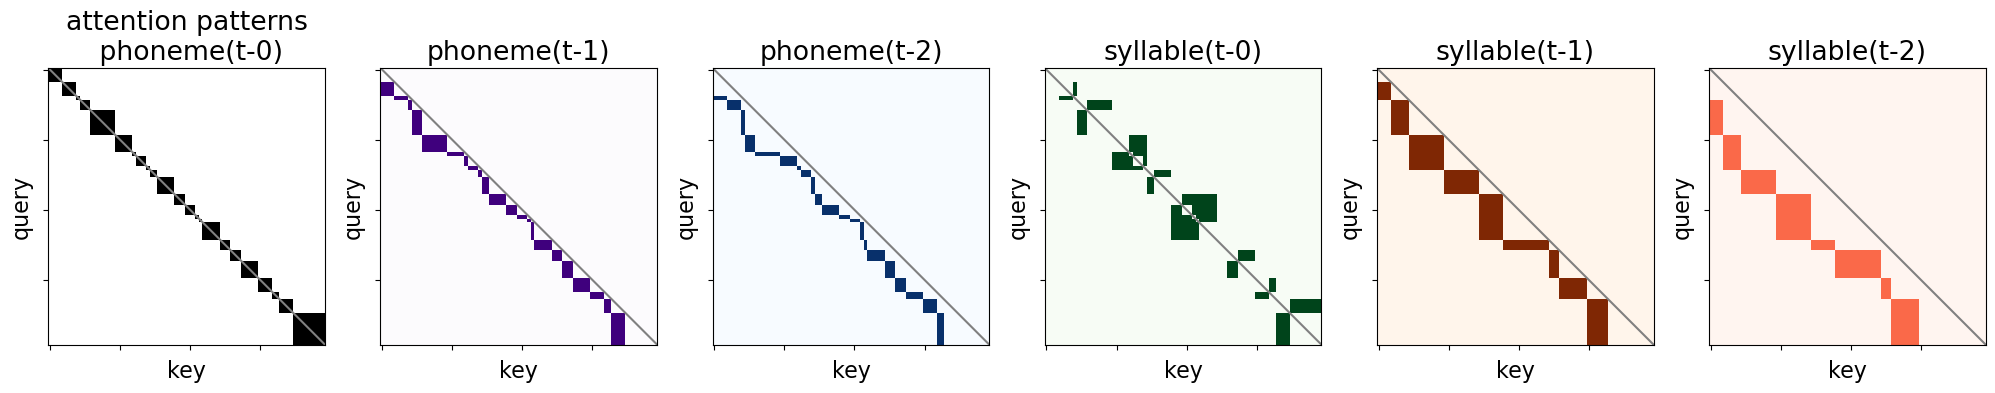

In [36]:
length = latent_attention[0][4][1][0].shape[0]
phon_masks = get_phoneme_masks(timit_names[4][1], length)
syll_masks = get_syllable_masks(timit_names[4][1], length)
matplotlib.rcParams.update({'font.size': 16})

cmaps = ['Greys','Purples', 'Blues', 'Greens', 'Oranges', 'Reds']

all_masks = get_masks(timit_names[4][1], length)

fig, axs = plt.subplots(1,6, figsize=(25,5))
axs = axs.flatten()
for i in range(len(axs)):
    axs[i].imshow(all_masks[i]*0.5, cmap=cmaps[i])
    axs[i].plot([0, 1], [1, 0], transform=axs[i].transAxes, color=[0.5,0.5,0.5])
    axs[i].set(xticklabels=[], yticklabels=[], xlabel='key', ylabel='query')
    for im in plt.gca().get_images():
        im.set_clim(0, 1)
    
axs[0].set(title='attention patterns\n phoneme(t-0)')
axs[1].set(title='phoneme(t-1)')
axs[2].set(title='phoneme(t-2)')
axs[3].set(title='syllable(t-0)')
axs[4].set(title='syllable(t-1)')
axs[5].set(title='syllable(t-2)')

# compute attention correlation scores

fisb0_si2209


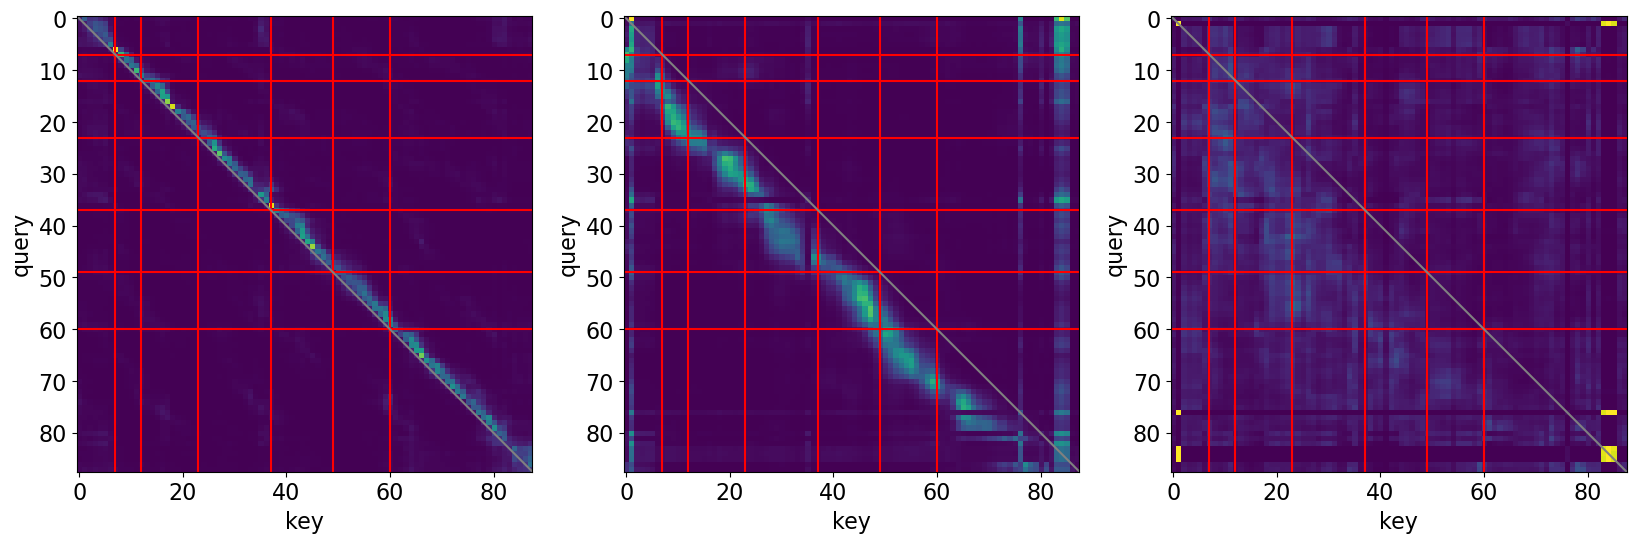

In [37]:
matplotlib.rcParams.update({'font.size': 16})
fig, axs = plt.subplots(1,3,figsize=(20,6))
timit_name = timit_names[1][1]
print(timit_name)
times = np.asarray(timit_syllables.loc[timit_name]['start_times'])
time_idx = util.time_to_index(times, hz=49)

axs[0].imshow(latent_attention[1][1][1][1], aspect='equal')
axs[1].imshow(latent_attention[5][1][1][8])
axs[2].imshow(latent_attention[4][1][1][3])

for i in range(3):
    for k in range(len(time_idx)):
        axs[i].axhline(time_idx[k], color='r')
        axs[i].axvline(time_idx[k], color='r')
    axs[i].plot([0, 1], [1, 0], transform=axs[i].transAxes, color=[0.5,0.5,0.5])
    axs[i].set(xlabel='key', ylabel='query')
for im in plt.gca().get_images():
    im.set_clim(0, 0.2)

fgmd0_si2107


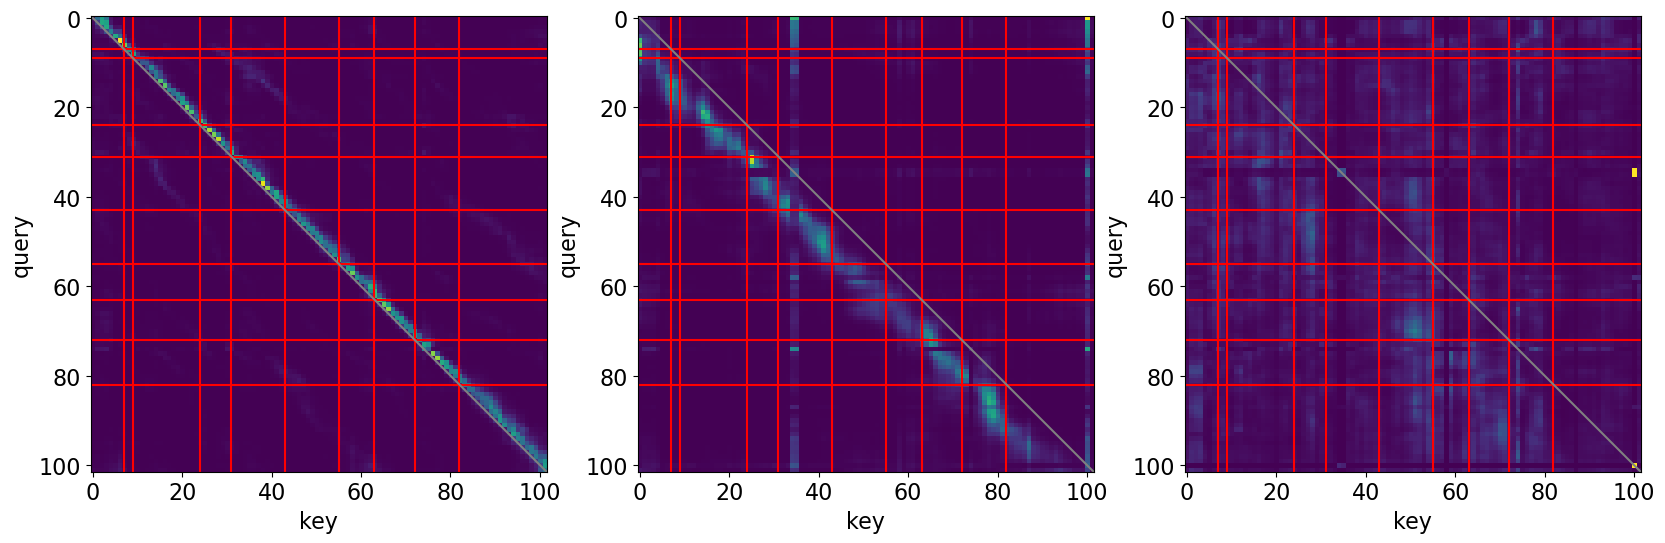

In [38]:
matplotlib.rcParams.update({'font.size': 16})
fig, axs = plt.subplots(1,3,figsize=(20,6))
timit_name = timit_names[3][1]
print(timit_name)
times = np.asarray(timit_syllables.loc[timit_name]['start_times'])
time_idx = util.time_to_index(times, hz=49)

axs[0].imshow(latent_attention[1][3][1][1], aspect='equal')
axs[1].imshow(latent_attention[5][3][1][8])
axs[2].imshow(latent_attention[4][3][1][3])

for i in range(3):
    for k in range(len(time_idx)):
        axs[i].axhline(time_idx[k], color='r')
        axs[i].axvline(time_idx[k], color='r')
    axs[i].plot([0, 1], [1, 0], transform=axs[i].transAxes, color=[0.5,0.5,0.5])
    axs[i].set(xlabel='key', ylabel='query')
for im in plt.gca().get_images():
    im.set_clim(0, 0.2)

In [39]:
def compute_correlations(A, B):
    m1 = A.flatten()
    m2 = B.flatten()
    return np.corrcoef(m1, m2)[0,1]

In [40]:
# unsupervised
attention_profiles_unsup = []  # attention_profiles[sentence][layer][head][mask]
num_layers = len(latent_attention)
num_heads = len(latent_attention[0][0][0])

counter = 0
for i in range(len(timit_names)):
    for j in range(len(timit_names[i])):
        timit_name = timit_names[i][j]
        attention_profiles_unsup.append([])
        for m in range(num_layers):
            attention_profiles_unsup[counter].append([])
            for n in range(num_heads):
                attention_profiles_unsup[counter][m].append([])
                
                att_weights = latent_attention[m][i][j][n]
                length = att_weights.shape[0]
                
                all_masks = get_masks(timit_name, length)
                for k in range(len(all_masks)):
                    corr = compute_correlations(all_masks[k], att_weights)
                    attention_profiles_unsup[counter][m][n].append(corr)
  
        counter += 1

In [41]:
att_results_unsup = np.asarray(attention_profiles_unsup)

mean_att_results_unsup = np.mean(np.abs(att_results_unsup), axis=0)
ste_att_results_unsup = np.std(att_results_unsup, axis=0)/np.sqrt(att_results_unsup.shape[0])

layer_mean_results_unsup = np.mean(mean_att_results_unsup, axis=1)

[Text(0.5, 1.0, 'layer average')]

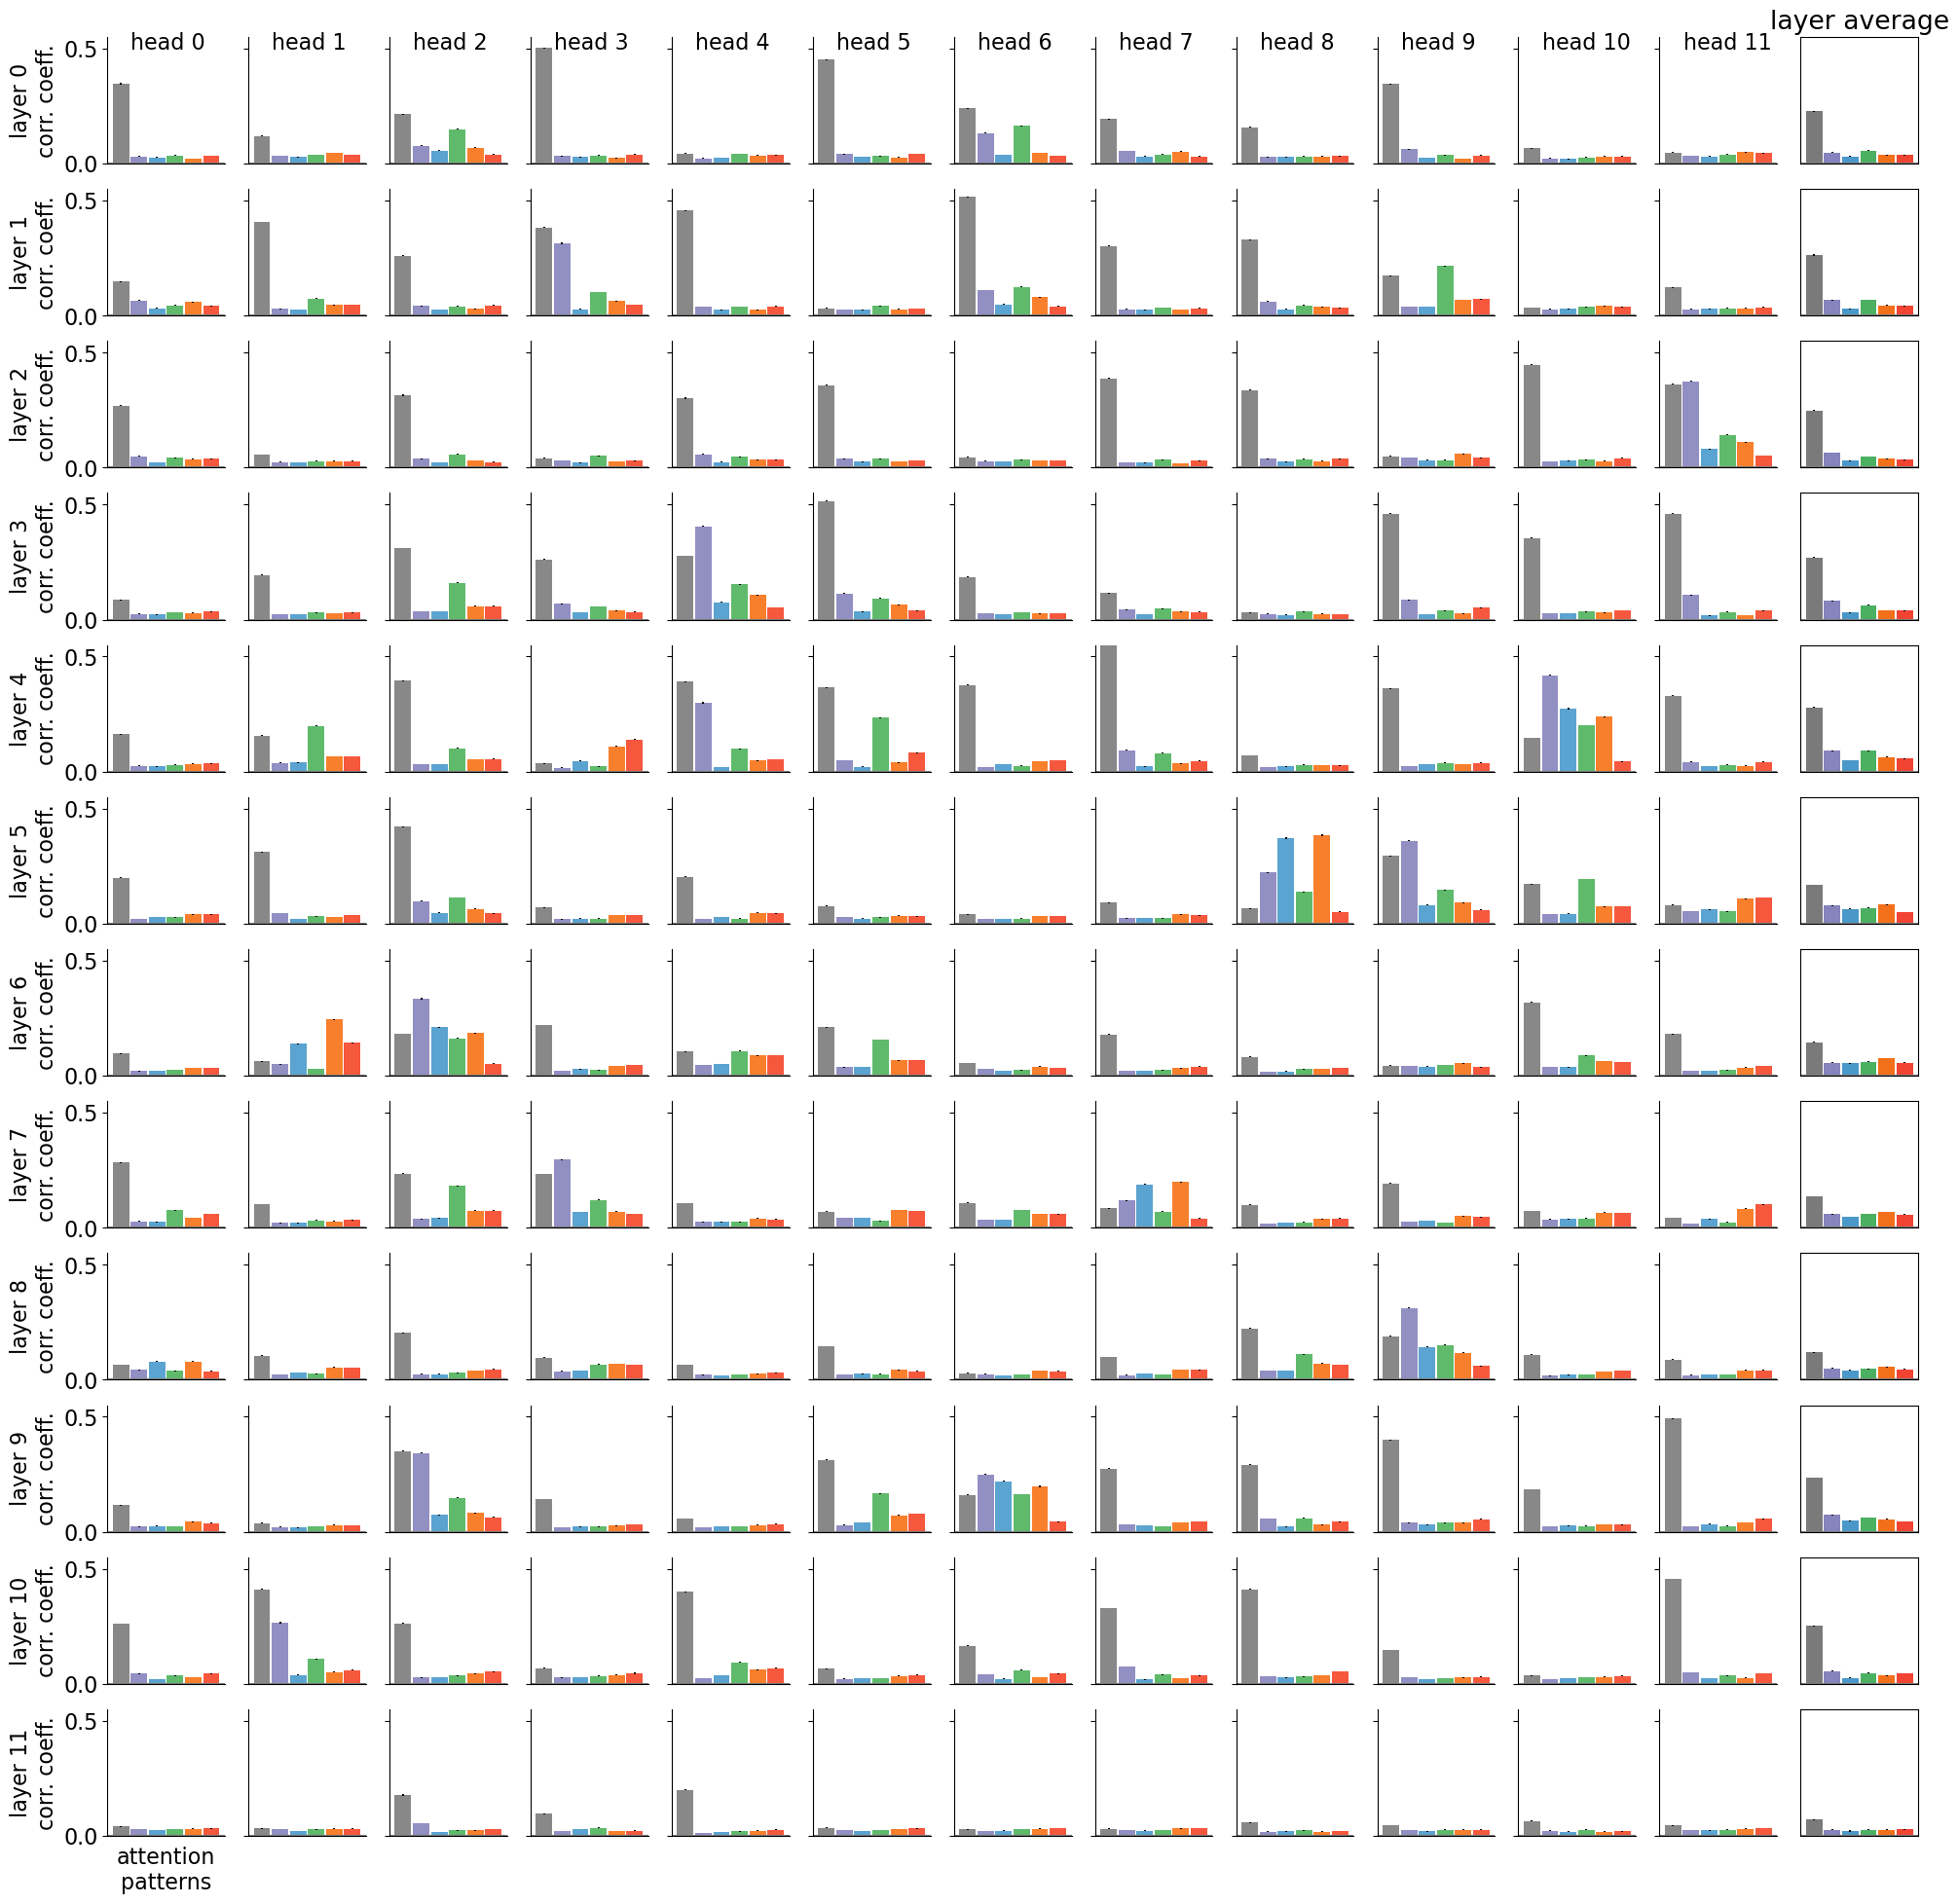

In [42]:
fig, axs = plt.subplots(12,13,figsize=(24,24))
step = 1.1
width = 1
offset = 0.46

for i in range(mean_att_results_unsup.shape[0]):
    for j in range(mean_att_results_unsup.shape[1]):
        axs[i][j].axhline(0, color=[0.5,0.5,0.5])
        for k in range(mean_att_results_unsup.shape[2]):
            axs[i][j].bar(k*step, mean_att_results_unsup[i][j][k], width=width, color=plt.get_cmap(cmaps[k])(0.55))
            axs[i][j].errorbar(x=k*step, y=mean_att_results_unsup[i][j][k], 
                               yerr=ste_att_results_unsup[i][j][k], color='k')
            

        axs[i][j].spines['right'].set_visible(False)
        axs[i][j].spines['top'].set_visible(False)
        axs[i][j].set(ylim=[0, 0.55], xticks=[])
        if j > 0:
            axs[i][j].set(yticklabels=[])
        axs[i][0].set(xticks=[], ylabel='layer {}\ncorr. coeff.'.format(i))
#     axs[i][0].text(0.1, 0.9, layers[i], transform=axs[i][0].transAxes)
axs[-1][0].set(xlabel='attention\npatterns')

for j in range(mean_att_results_unsup.shape[1]):
    axs[0][j].text(0.2, 0.9, 'head {}'.format(j), transform=axs[0][j].transAxes)

for i in range(mean_att_results_unsup.shape[0]):
    axs[i][-1].axhline(0, color=[0.5,0.5,0.5])
    for j in range(layer_mean_results_unsup.shape[1]):
        axs[i][-1].bar(j*step, layer_mean_results_unsup[i][j], width=width, color=plt.get_cmap(cmaps[j])(0.6))
        axs[i][-1].errorbar(x=j*step, y=layer_mean_results_unsup[i][j], 
                   yerr=ste_att_results_unsup[i][j][0], color='k')

        axs[i][-1].set(ylim=[0, 0.55], xticks=[], yticks=[])
axs[0][-1].set(title='layer average')